# Part 1: Introduction
The goal of this colab is to introduce the core abstractions used within this library.
These include the `Task` and `Optimizer` objects.

We will first introduce these abstractions and illustrate basic functionality. We will then show how to define a custom `Optimizer`, and how to optimize optimizers via gradient-based meta-training.

This colab serves as a brief, limited introduction to the capabilities of the library. Further notebooks introduce further functionality as well as more complex learned optimizer models.

## Prerequisites

This document assumes knowledge of JAX which is covered in depth at the [JAX Docs](https://jax.readthedocs.io/en/latest/index.html).
In particular, we would recomend making your way through [JAX tutorial 101](https://jax.readthedocs.io/en/latest/jax-101/index.html).

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
from matplotlib import pylab as plt

In [ ]:
!pip install git+https://github.com/google/learned_optimization.git

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
from matplotlib import pylab as plt

from learned_optimization.outer_trainers import full_es
from learned_optimization.outer_trainers import truncated_pes
from learned_optimization.outer_trainers import gradient_learner
from learned_optimization.outer_trainers import truncation_schedule

from learned_optimization.tasks import quadratics
from learned_optimization.tasks.fixed import image_mlp
from learned_optimization.tasks import base as tasks_base
from learned_optimization.tasks.datasets import base as datasets_base

from learned_optimization.learned_optimizers import base as lopt_base
from learned_optimization.learned_optimizers import mlp_lopt
from learned_optimization.optimizers import base as opt_base

from learned_optimization import optimizers
from learned_optimization import eval_training

import haiku as hk
import tqdm

## Tasks

A `Task` is an object containing a specification of a machine learning or optimization problem. The `Task` requires:
  * Parameters: for example, these may include the decision variables of an arbitrary optimization problem, or parameters of a predictive model such as a neural network. These are initialized through the `init` method.
  * Optionally a model state: this includes model parameters which are not to be updated via gradients. One example is the running population statistics used within batch norm.
  * Optionally, a `.dataset` attribute with iterators of datasets.
  * A loss function: this maps from the parameters, and possibly a batch of data to a loss.

This object can be thought of as a loss function, and these are the base objects we train learned optimizers to perform well on.

Tasks contain the following:
  * A `init` function which initializes the parameters of the task.
  * A `loss` function, which evaluates the loss given parameters and data.
  * Optionally a `.dataset` attribute with iterators of datasets.

For tasks which make use of a model state (e.g. tasks with batchnorm), a `init_with_state` and `loss_with_state` will also be provided.

We'll begin by looking at some built-in tasks in the library. In future colabs, we will discuss how custom tasks can be designed, and how families of tasks can be efficiently designed for parallelization.

We will look at the `ImageMLP_FashionMnist8_Relu32` task. This task consists of a 1 hidden layer MLP trained on Fashion MNIST resized to 8x8.

First, let's initialize the parameters.

In [ ]:
key = jax.random.PRNGKey(0)
task = image_mlp.ImageMLP_FashionMnist8_Relu32()

params = task.init(key)
jax.tree_util.tree_map(lambda x: x.shape, params)

{'mlp/~/linear_0': {'b': (32,), 'w': (64, 32)},
 'mlp/~/linear_1': {'b': (10,), 'w': (32, 10)}}

We can see we initialized parameters which correspond to the weights of the MLP.

Next, let's look at the data.

In [ ]:
batch = next(task.datasets.train)
jax.tree_util.tree_map(lambda x: (x.shape, x.dtype), batch)

FlatMap({
  'image': ((128, 8, 8, 1), dtype('float32')),
  'label': ((128,), dtype('int32')),
})

We get batches of 128 with images of size 8x8 and labels stored as integers.

To compute losses, we can call the `loss` function. Some loss functions can be stochastic. For these, in addition to passing in params, and the batch of data, we also pass in a random number.

In [ ]:
key, key1 = jax.random.split(key)

loss = task.loss(params, key1, batch)
loss

DeviceArray(2.3404593, dtype=float32)

Function transformations can also be used to compute gradients.

In [ ]:
loss, grad = jax.value_and_grad(task.loss)(params, key1, batch)
jax.tree_util.tree_map(lambda x: x.shape, grad)

{'mlp/~/linear_0': {'b': (32,), 'w': (64, 32)},
 'mlp/~/linear_1': {'b': (10,), 'w': (32, 10)}}

Now let's pull this together to train this task with SGD. Note that we will _jit_ the loss gradient computation for improved performance---if this is not familiar, we recommend reading about [Just in Time Compilation with JAX](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html).

In [ ]:
grad_fn = jax.jit(jax.value_and_grad(task.loss))
key = jax.random.PRNGKey(0)
params = task.init(key)
lr = 0.1

for i in range(1000):
  key, key1 = jax.random.split(key)
  batch = next(task.datasets.train)
  l, grads = grad_fn(params, key1, batch)
  # apply SGD to each parameter
  params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, grads)
  if i % 100 == 0:
    test_l = task.loss(params, key, next(task.datasets.test))
    print(f"train loss at {i}: {float(l)}. Test loss: {float(test_l)}")

train loss at 0: 2.3431787490844727. Test loss: 2.3290696144104004
train loss at 100: 1.3063488006591797. Test loss: 1.3161423206329346
train loss at 200: 1.0361652374267578. Test loss: 0.9567877054214478
train loss at 300: 0.8567416667938232. Test loss: 0.8595446348190308
train loss at 400: 0.7901570796966553. Test loss: 0.7775527238845825
train loss at 500: 0.7749090194702148. Test loss: 0.8601065874099731
train loss at 600: 0.717944860458374. Test loss: 1.0189208984375
train loss at 700: 0.664547324180603. Test loss: 0.639930784702301
train loss at 800: 0.5981862545013428. Test loss: 0.6370106935501099
train loss at 900: 0.6088892817497253. Test loss: 0.8031588792800903


Note the evaluations in the above are quite noisy as they are only done on a single batch of data.

## Optimizers
We have so far implemented a rough SGD optimizer to train our model parameters. In this section, we will develop useful abstractions to create more powerful optimizers.

Sadly there is no gold standard interface for optimizers in Jax: there are Flax's optimizers, optax optimizers, optimizers from jaxopt, and optix. This library uses it's own interface to expose additional types of inputs to the optimizer. These additional inputs will become more obvious when we discuss learned optimizers later in this colab, as well as in future colabs.


In this library, optimizers are stateless classes that implement:
  * an `init` which creates an `OptimizerState` instance which wraps parameters and optionally a model stats as well as contains any additional optimizer state needed (e.g. momentum values)
  * a `get_params` and `get_state`  which return the parameters and state of the `OptimizerState`.
  * an `update` function which takes in a previous optimizer state, gradients, and optionally a loss values to produce a new `OptimizerState` (with new parameters).


Let's look at a couple examples. First, SGD:

In [ ]:
fake_params = {"a": jnp.zeros((2,))}

opt = opt_base.SGD(1e-4)
opt_state = opt.init(fake_params)
opt_state

OptaxState(params={'a': DeviceArray([0., 0.], dtype=float32)}, state=None, optax_opt_state=(EmptyState(), EmptyState()), iteration=0)

We can see the `opt_state` has parameter values, and a couple other values such as current iteration.

In [ ]:
opt = opt_base.Adam(1e-4)
opt_state = opt.init(fake_params)
opt_state

OptaxState(params={'a': DeviceArray([0., 0.], dtype=float32)}, state=None, optax_opt_state=(ScaleByAdamState(count=DeviceArray(0, dtype=int32), mu={'a': DeviceArray([0., 0.], dtype=float32)}, nu={'a': DeviceArray([0., 0.], dtype=float32)}), EmptyState()), iteration=0)

Adam, on the other hand, has more data inside as it contains first and second moment accumulators.

Now let's take one step with an optimizer.

In [ ]:
fake_grads = {"a": jnp.ones((2,))}
fake_loss = 10.

next_opt_state = opt.update(opt_state, fake_grads, fake_loss)
opt.get_params(next_opt_state)

{'a': DeviceArray([-9.9999335e-05, -9.9999335e-05], dtype=float32)}

We can see the parameters of our model have been updated slightly.

Now let's pull this all together and train a Task with this optimizer API.

In [ ]:
task = image_mlp.ImageMLP_FashionMnist8_Relu32()
key = jax.random.PRNGKey(0)
params = task.init(key)

opt = opt_base.Adam(1e-2)
opt_state = opt.init(params)

for i in range(10):
  batch = next(task.datasets.train)
  key, key1 = jax.random.split(key)
  params = opt.get_params(opt_state)
  loss, grads = jax.value_and_grad(task.loss)(params, key1, batch)
  opt_state = opt.update(opt_state, grads, loss)
  print(loss)

2.3285213
2.2702265
2.2235658
2.1345925
2.0540721
2.039238
1.922206
1.847055
1.8123329
1.7331252


The above doesn't make use of any sort of `jax.jit` and thus it is slow. In practice, we often like to create one update function which maps from one `opt_state` to the next and jit this entire function. For example:

In [ ]:
task = image_mlp.ImageMLP_FashionMnist8_Relu32()
key = jax.random.PRNGKey(0)
params = task.init(key)

opt = opt_base.Adam(1e-2)
opt_state = opt.init(params)


@jax.jit
def update(opt_state, key, batch):
  key, key1 = jax.random.split(key)
  params, model_state = opt.get_params_state(opt_state)
  loss, grads = jax.value_and_grad(task.loss)(params, key1, batch)
  opt_state = opt.update(opt_state, grads, loss=loss)

  return opt_state, key, loss


for i in range(10):
  batch = next(task.datasets.train)
  opt_state, key, loss = update(opt_state, key, batch)
  print(loss)

2.3393626
2.259151
2.1479445
2.0973787
2.089923
2.012719
1.8739626
1.8503203
1.7333521
1.6747149


### Defining a custom `Optimizer`

To define a custom optimizer, one simply needs to define a stateless instance of the `Optimizer` class and some pytree object with the optimizer state.

As an example let's implement the momentum optimizer. As our state we will use a flax dataclass (though a simple dictionary or named tuple would also suffice).

In [ ]:
import flax
from typing import Any


@flax.struct.dataclass
class MomentumOptState:
  params: Any
  model_state: Any
  iteration: jnp.ndarray
  momentums: Any


class MomentumOptimizer(opt_base.Optimizer):

  def __init__(self, lr=1e-3, momentum=0.9):
    super().__init__()
    self._lr = lr
    self._momentum = momentum

  def get_state(self, opt_state):
    return opt_state.model_state

  def get_params(self, opt_state):
    return opt_state.params

  def init(self, params, model_state=None, **kwargs):
    return MomentumOptState(
        params=params,
        model_state=model_state,
        momentums=jax.tree_util.tree_map(jnp.zeros_like, params),
        iteration=jnp.asarray(0, dtype=jnp.int32))

  def update(self, opt_state, grads, loss, model_state=None, **kwargs):
    struct = jax.tree_util.tree_structure(grads)
    flat_momentum = jax.tree_util.tree_leaves(opt_state.momentums)
    flat_grads = jax.tree_util.tree_leaves(grads)
    flat_params = jax.tree_util.tree_leaves(opt_state.params)

    output_params = []
    output_momentums = []
    for m, g, p in zip(flat_momentum, flat_grads, flat_params):
      next_m = m * self._momentum + g * (1 - self._momentum)
      next_p = p - next_m * self._lr
      output_params.append(next_p)
      output_momentums.append(next_m)
    return MomentumOptState(
        params=jax.tree_util.tree_unflatten(struct, output_params),
        model_state=model_state,
        iteration=opt_state.iteration + 1,
        momentums=jax.tree_util.tree_unflatten(struct, output_params),
    )


opt = MomentumOptimizer(lr=1)
opt_state = opt.init({"a": 1.0, "b": 2.0})
opt.update(opt_state, {"a": -1.0, "b": 1.0}, 1.0)

MomentumOptState(params={'a': DeviceArray(1.1, dtype=float32, weak_type=True), 'b': DeviceArray(1.9, dtype=float32, weak_type=True)}, model_state=None, iteration=DeviceArray(1, dtype=int32), momentums={'a': DeviceArray(1.1, dtype=float32, weak_type=True), 'b': DeviceArray(1.9, dtype=float32, weak_type=True)})

## Learned Optimizers

Learned optimizers are simply optimizers parameterized by some additional set of variables, often called `theta` by convention.

Like before, instances of `LearnedOptimizer` should contain no immutable state.

They implement 2 functions:
  * `init` which initializes the weights of the learned optimizer (e.g. randomly as done with neural networks, or with some fixed values).
  * `opt_fn` which takes in the parameters of the learned optimizer, and produces an `Optimizer` instance.


One of the simplest forms of learned optimizer is a hand-designed optimizer with meta-learnable hyperparameters. Let's look at `LearnableAdam`:

In [ ]:
lopt = lopt_base.LearnableAdam()
theta = lopt.init(key)
theta

{'log_epsilon': DeviceArray(-18.420681, dtype=float32, weak_type=True),
 'log_lr': DeviceArray(-6.9077554, dtype=float32, weak_type=True),
 'one_minus_beta1': DeviceArray(-2.3025851, dtype=float32, weak_type=True),
 'one_minus_beta2': DeviceArray(-6.9077554, dtype=float32, weak_type=True)}

We see this optimizer has 4 meta-learnable parameters corresponding to log learning rate, 2 values for beta (parameterized as the log of one minus the beta values), and log epsilon.

We can access an instance of the optimizer with the opt_fn, and use that optimizer just like the ones in the previous section.

In [ ]:
opt = lopt.opt_fn(theta)
opt_state = opt.init({"p": jnp.zeros([
    2,
])})

With our optimizers split up in this way we can now write functions that are a function of the learned optimizer weights.

As an example, let us define a function, `meta_loss` which is the result of applying a learned optimizer to a given problem for some number of steps.

In [ ]:
task = image_mlp.ImageMLP_FashionMnist8_Relu32()
key = jax.random.PRNGKey(0)

lopt = lopt_base.LearnableAdam()


def meta_loss(theta, key, batch):
  opt = lopt.opt_fn(theta)
  key1, key = jax.random.split(key)
  param = task.init(key1)
  opt_state = opt.init(param)
  for i in range(4):
    param = opt.get_params(opt_state)
    key1, key = jax.random.split(key)
    l, grad = jax.value_and_grad(task.loss)(param, key1, batch)
    opt_state = opt.update(opt_state, grad, l)

  param, state = opt.get_params_state(opt_state)
  key1, key = jax.random.split(key)
  final_loss = task.loss(param, key1, batch)
  return final_loss


batch = next(task.datasets.train)
meta_loss(theta, key, batch)

DeviceArray(2.2636137, dtype=float32)

But let's not stop there, we can leverage jax now to easily compute meta-gradients, or gradients with respect to the weights of the learned optimizer. This will take a bit to compile (~20 seconds on my machine) as this computation graph is a bit complex. Note: this can be greatly reduced by leveraging `jax.lax.scan`!

In [ ]:
meta_value_and_grad = jax.jit(jax.value_and_grad(meta_loss))

ml, meta_grad = meta_value_and_grad(theta, key, batch)
meta_grad

{'log_epsilon': DeviceArray(7.518652e-08, dtype=float32, weak_type=True),
 'log_lr': DeviceArray(-0.04048448, dtype=float32, weak_type=True),
 'one_minus_beta1': DeviceArray(-3.1022726e-05, dtype=float32),
 'one_minus_beta2': DeviceArray(-2.4318695e-07, dtype=float32)}

We can see that this meta-gradient is saying we should increase the log learning rate to improve performance.

We can now meta-train by using an additional optimizer -- this time to optimize `theta`, the weights of the learned optimizer.

In [ ]:
theta_opt = opt_base.Adam(1e-2)

key = jax.random.PRNGKey(0)
theta = lopt.init(key)
theta_opt_state = theta_opt.init(theta)

learning_rates = []
learnable_adam_meta_losses = []
for i in range(2000):
  batch = next(task.datasets.train)
  key, key1 = jax.random.split(key)
  theta = theta_opt.get_params(theta_opt_state)
  ml, meta_grad = meta_value_and_grad(theta, key, batch)
  theta_opt_state = theta_opt.update(theta_opt_state, meta_grad, ml)
  learning_rates.append(theta["log_lr"])
  learnable_adam_meta_losses.append(ml)
  if i % 100 == 0:
    print(ml)

2.2463012
2.2374353
1.75054
1.3767055
1.0847464
1.1990764
1.3325281
1.2866051
1.1671047
1.1733787
1.5384903
1.1215551
1.123384
1.2072926
1.1499238
1.1710639
1.3856463
1.4461384
1.1795483
1.1503576


Text(0.5, 0, 'meta-iteration')

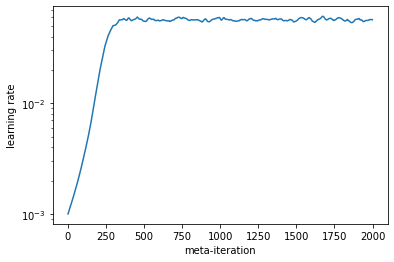

In [ ]:
import numpy as np
from matplotlib import pylab as plt

plt.semilogy(np.exp(learning_rates))
plt.ylabel("learning rate")
plt.xlabel("meta-iteration")

And there you have it: we have used gradient-based meta-training to train the hyperparameters of our Adam optimizer! This is the core idea in learned optimizers.

Fitting a handful of scalars is a relatively simple application of the tools we have developed. In this library there are a number of more complex learned optimizers. We will explore these models, as well as more complex library functionality, in the next colab notebook.